{{title_s1_5}}

So far in this tutorial, we've demonstrated how to read Sentinel-1 RTC imagery from two sources and assemble analysis-ready data cubes with appropriate metadata. Now, we'll perform a comparison of the two datasets. 

::::{tab-set}
:::{tab-item} Dataset comparison

While the two datasets are very similar, there are a few key differences:  
1) They use different sources images.   
    - ASF Sentinel-1 RTC imagery is processed from Single Look Complex ([SLC](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/single-look-complex)) images while Planetary Computer Sentinel-1 RTC imagery is processed from Ground Range Detected ([GRD](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/ground-range-detected)) images. SLC images contain both amplitude and phase information for each pixel. They are in radar coordinates and have not yet been multi-looked. In contrast, GRD images has been detected, multi-looked and projected to ground range.

2) They use different digital elevation models (DEMs) for terrain correction.  
    - ASF uses the [GLO-30 Copernicus DEM](https://dataspace.copernicus.eu/explore-data/data-collections/copernicus-contributing-missions/collections-description/COP-DEM) while Planetary Computer uses a Planet DEM.  
3) The datasets have different pixel spacings. For Planetary Computer, the pixel spacing is 10m in both range and azimuth directions. ASF has the option to produce images with 30 m, 20 m, or 10 m pixel spacaing. The data used in this tutorial is 30 m. Note that there are tradeoffs in processing time and file size with pixel spacing, see more discussion [here](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#pixel-spacing_1).  
4) Each platform uses a different algorithm for RTC processing.
5) The ASF dataset comes with an associated layover shadow map for each scene while the Planetary Computer dataset does not.  

All of the above information and much more detail about the processing methods for both datasets are available in each dataset's documentation pages:
- [ASF Sentinel-1 RTC Product Guide](https://hyp3-docs.asf.alaska.edu/guides/rtc_product_guide/#pixel-spacing_1)  
- [Microsoft Planetary Computer Sentinel-1 RTC dataset](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) 
::: 

:::{tab-item} Outline

(content.Section_A)=
**[A. Read and prepare data](#a-read-and-prepare-data)**  
-{{a1_s1_nb5}}  

(content.Section_B)=
**[B. Ensure direct comparison between datasets](#b-ensure-direct-comparison-between-datasets)**
- {{b1_s1_nb5}}
- {{b2_s1_nb5}}
- {{b3_s1_nb5}}

(content.Section_C)=
**[C. Combine objects](#c-combine-objects)**
- {{c1_s1_nb5}}
- {{c2_s1_nb5}}

(content.Section_D)=
**[D. Visualize comparisons](#d-visualize-comparisons)**
- {{d1_s1_nb5}}
- {{d2_s1_nb5}}

:::
:::{tab-item} Learning goals

## Xarray and python techniques
- Conditional selection based on non-dimensional coordinates using `xr.Dataset.where()`
- Subsetting datasets based on dimensional coordinates using `xr.DataArray.isin()`
- Adding dimensional and non-dimensional coordinates to `xr.Dataset` objects
- Xarray plotting methods
- Projecting xarray objects to different grids using `xr.interp_like()`

## High-level science goals
- Comparing and evaluating multiple datasets
- Setting up multiple datasets for direct comparisons
- Handling differences in spatial resolution 

:::
::::


In [1]:
%xmode minimal
import dask.distributed
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import stackstac
import xarray as xr
import pystac
import planetary_computer

from dask.distributed import Client

import s1_tools

%matplotlib inline

Exception reporting mode: Minimal


{{break}}

## A. Read and prepare data

At the end of notebook 3, we wrote the analysis-ready ASF Sentinel-1 data cube that had been clipped to a smaller spatial area of interest to disk. We'll read that into memory now to use in this comparison.

(old)The Planetary Computer dataset is a bit larger. To avoid writing it to disk and since there is less processing needed to prepare it for analysis, we'll read it again like in notebook 4. 

We used Jupyter cell magic to persist the Planetary Computer data cube created in noteboook 4. Now we can read it into our notebook by adding `-r` to the store magic command used to persist it. Read more about `storemagic` [here](https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html).

In [2]:
%store -r da
pc_cube = da

In [3]:
pc_cube = pc_cube.compute()

In [4]:
asf_cube = xr.open_dataset('../data/s1_asf_clipped_cube.zarr',
                           engine='zarr',chunks='auto', decode_coords='all')

In [5]:
asf_cube

<xarray.Dataset> Size: 176MB
Dimensions:        (acq_date: 96, y: 396, x: 290)
Coordinates:
    abs_orbit_num  (acq_date) <U6 2kB dask.array<chunksize=(96,), meta=np.ndarray>
  * acq_date       (acq_date) datetime64[ns] 768B 2021-05-02T12:14:14 ... 202...
    data_take_ID   (acq_date) <U6 2kB dask.array<chunksize=(96,), meta=np.ndarray>
    ls             (acq_date, y, x) float64 88MB dask.array<chunksize=(20, 396, 290), meta=np.ndarray>
    orbital_dir    (acq_date) <U4 2kB dask.array<chunksize=(96,), meta=np.ndarray>
    product_id     (acq_date) <U4 2kB dask.array<chunksize=(96,), meta=np.ndarray>
    spatial_ref    int64 8B ...
  * x              (x) float64 2kB 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y              (y) float64 3kB 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
Data variables:
    vh             (acq_date, y, x) float32 44MB dask.array<chunksize=(30, 396, 290), meta=np.ndarray>
    vv             (acq_date, y, x) float32 44MB dask.array<chunksize=(30, 396, 290), meta=np.ndarray>
Attributes: (12/13)
    area_or_clipped:                   e
    beam_mode:                         IW
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    orbit_type:                        P
    output_type:                       g
    ...                                ...
    polarization_type:                 D
    primary_polarization:              V
    processing_software:               G
    sensor:                            S1A
    terrain_correction_pixel_spacing:  RTC30
    unmasked_or_watermasked:           u

In [6]:
asf_cube = asf_cube.compute()

### {{a1_s1_nb5}}

First, make sure that both objects are projected to the same CRS.

In [7]:
assert pc_cube.rio.crs == asf_cube.rio.crs, 'CRS of both data cubes are expected to be identical.'

Let's also check how mising data is handled in both objects. We want missing data to be assigned NaN values.

In [8]:
asf_cube['vv'].rio.nodata

nan

In [9]:
pc_cube.sel(band='vv').rio.nodata

The `pc_cube` array contains nan values, but it doesn't have an encoding specifying what value is used to represent nodata. We can assign a nodata value to the dataset below. See Rioxarray's [Nodata Management documentation](https://corteva.github.io/rioxarray/stable/getting_started/nodata_management.html) for more detail on this.

In [10]:
pc_cube.rio.write_nodata(np.nan, inplace=True)
pc_cube.rio.nodata

nan

In [11]:
assert np.isnan(asf_cube.vh.rio.nodata) == np.isnan(pc_cube.sel(band='vh').rio.nodata) == True, 'Expected vh nodata value to be np.nan'
assert np.isnan(asf_cube.vv.rio.nodata) == np.isnan(pc_cube.sel(band='vv').rio.nodata) == True, 'Expected vv nodata value to be np.nan'

## B. Ensure direct comparison between datasets

Both objects have temporal dimensions with the same length, so we can be reasonably sure that these two objects have common acquisitions but we can do a few more things to be sure about that. 

Thanks to all of the metadata wrangling we did in earlier notebooks, we can quickly access variables like acquisition date and time, data take IDs and absolute orbit numbers to verify that the we're working with comparable objects.

### {{b1_s1_nb5}}

If we try to compare orbit numbers right away (eg: `asf_cube['abs_orbit_num'].data == pc_cube['sat:absolute_orbit']`), we will get that they are false. This is because the data in the underlying numpy arrays is currently not of the same type:

In [12]:
print(asf_cube['abs_orbit_num'].data.dtype)
print(pc_cube['sat:absolute_orbit'].data.dtype)

<U6
int64


Convert the absolute orbit array of `asf_cube` to an array of integers:

In [13]:
asf_cube['abs_orbit_num'] = asf_cube['abs_orbit_num'].astype(int)
                                                             

Now compare them:

In [14]:
asf_cube['abs_orbit_num'].data == pc_cube['sat:absolute_orbit'].data

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

### {{b2_s1_nb5}}

The PC dataset has a higher spatial resolution than the ASF dataset, which you can see in the sizes of the x and y dimensions of the dataset. The ASF dataset masks out more pixels due to shadow than the PC dataset. To explore whether or not this is the cause of the observed backscatter offset between the two, we need to mask out the pixels in the PC dataset that are masked in the ASF dataset. 

In order to do this, first we must downsample the PC dataset to match the spatial resolution of the ASF dataset. There are multiple xarray methods that could be used but here we will use the `xr.interp_like()` method because we would like the PC x and y dimensions to match the ASF dimension exactly. 

In [15]:
asf_cube = asf_cube.rename({"acq_date": "time"})

In [27]:
import geopandas as gpd
from shapely.geometry import Polygon
def get_bounds_polygon(input_xr: xr.Dataset) -> gpd.GeoDataFrame:
    """
    Generate a GeoDataFrame containing a polygon that represents the bounding box of the input xarray Dataset.
    Parameters
    ----------
    input_xr : xr.Dataset
        An xarray Dataset containing 'x' and 'y' coordinates.
    Returns
    -------
    gpd.GeoDataFrame
        A GeoDataFrame with a single polygon geometry representing the bounding box of the input dataset.
    """

    xmin = input_xr.coords["x"].data.min()
    xmax = input_xr.coords["x"].data.max()

    ymin = input_xr.coords["y"].data.min()
    ymax = input_xr.coords["y"].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]

    #crs = f"epsg:{input_xr.mapping.spatial_epsg}"
    crs = 'EPSG:32645'

    polygon_geom = Polygon(pts_ls)
    polygon_gdf = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])

    return polygon_gdf

In [29]:
asf_bbox = get_bounds_polygon(asf_cube)
pc_bbox = get_bounds_polygon(pc_cube)

<Axes: >

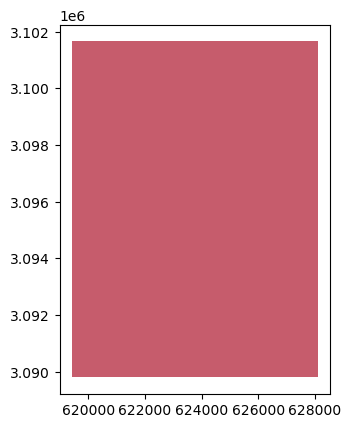

In [32]:
fig, ax = plt.subplots()

asf_bbox.plot(ax=ax, alpha=0.5)
pc_bbox.plot(ax=ax, alpha=0.5, color='r')

In [16]:
asf_da = asf_cube.to_dataarray(dim='band')

In [168]:
pc_downsample = pc_cube.interp_like(asf_da)

### {{b3_s1_nb5}}

In [169]:
pc_mask = xr.where(asf_da.notnull(), pc_downsample, np.nan)

## C. Combine objects

### {{c1_s1_nb5}}

In [170]:
asf_da = asf_da.expand_dims('source')
pc_mask = pc_mask.expand_dims('source')

In [171]:
asf_da['source'] = ('source', ['asf'])
pc_mask['source'] = ('source', ['pc'])

### {{c2_s1_nb5}}

In [172]:
comparison_obj = xr.combine_by_coords([asf_da, pc_mask])

In [173]:
comparison_obj

<xarray.DataArray (source: 2, band: 2, time: 96, y: 396, x: 290)> Size: 353MB
array([[[[[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          ...,
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]],

         [[0.01555569, 0.01491176, 0.0143311 , ..., 0.01184858,
           0.0117538 , 0.00992225],
          [0.01360236, 0.01293999, 0.01243569, ..., 0.01579912,
           0.0168997 , 0.01891696],
          [0.01288445, 0.01205768, 0.01015107, ..., 0.01416875,
           0.01364833, 0.01188905],
...
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]],

         [[       nan,        nan,        nan, ..., 0.02990937,
           0.06168118, 0.10338297],
          [       nan,        nan,        nan, ..., 0.06324501,
           0.06967312, 0.06998666],
          [       nan,        nan,        nan, ..., 0.13871039,
           0.16923553, 0.09101629],
          ...,
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]]]]])
Coordinates: (12/46)
    abs_orbit_num                          (time) int64 768B 37709 ... 43309
  * time                                   (time) datetime64[ns] 768B 2021-05...
    data_take_ID                           (time) <U6 2kB '047321' ... '052C00'
    ls                                     (time, y, x) float64 88MB nan ... 1.0
    orbital_dir                            (time) <U4 2kB 'desc' ... 'desc'
    product_id                             (time) <U4 2kB '1424' ... 'CA1B'
    ...                                     ...
    s1:orbit_source                        (time) <U8 3kB 'DOWNLINK' ... 'RES...
    start_datetime                         (time) <U32 12kB '2021-05-02 12:13...
    s1:instrument_configuration_ID         (time) <U1 384B '6' '6' ... '7' '7'
    s1:total_slices                        (time) <U2 768B '20' '17' ... '20'
    sat:orbit_state                        (time) <U10 4kB 'ascending' ... 'a...
    s1:slice_number                        (time) <U2 768B '6' '12' ... '6' '6'
Attributes: (12/13)
    area_or_clipped:                   e
    beam_mode:                         IW
    deadreckoning_or_demmatch:         d
    notfiltered_or_filtered:           n
    orbit_type:                        P
    output_type:                       g
    ...                                ...
    polarization_type:                 D
    primary_polarization:              V
    processing_software:               G
    sensor:                            S1A
    terrain_correction_pixel_spacing:  RTC30
    unmasked_or_watermasked:           u

## D. Visualize comparisons

### {{d1_s1_nb5}}

Look at VV backscatter first:

''

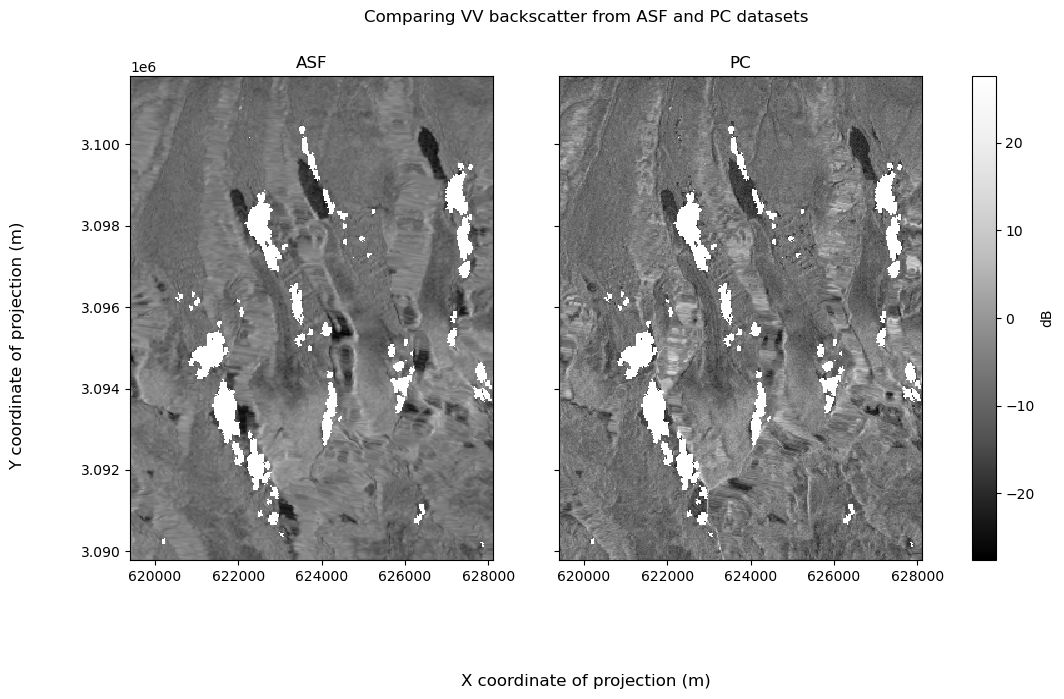

In [174]:
vv_fg = s1_tools.power_to_db(comparison_obj.sel(band='vv').isel(time=1)).plot(col='source', 
                                                cmap=plt.cm.Greys_r, cbar_kwargs=({'label':'dB'}))
vv_fg.fig.suptitle('Comparing VV backscatter from ASF and PC datasets')
vv_fg.fig.supxlabel('X coordinate of projection (m)')
vv_fg.fig.supylabel('Y coordinate of projection (m)')
vv_fg.fig.set_figheight(7)
vv_fg.fig.set_figwidth(12)

for i in range(len(vv_fg.axs[0])):
    
    vv_fg.axs[0][i].set_xlabel(None)
    vv_fg.axs[0][i].set_ylabel(None)
vv_fg.axs[0][0].set_title('ASF')
vv_fg.axs[0][1].set_title('PC')
;

Then VH:

''

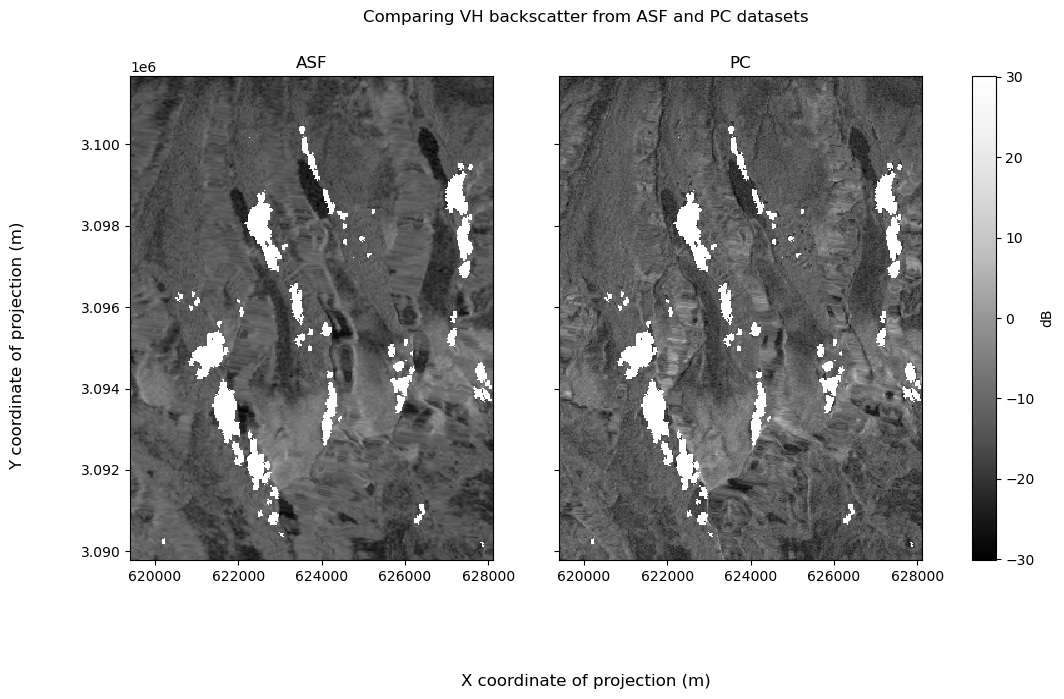

In [175]:
vh_fg = s1_tools.power_to_db(comparison_obj.sel(band='vh').isel(time=1)).plot(col='source', 
                                                cmap=plt.cm.Greys_r, cbar_kwargs=({'label':'dB'}))
vh_fg.fig.suptitle('Comparing VH backscatter from ASF and PC datasets')
vh_fg.fig.supxlabel('X coordinate of projection (m)')
vh_fg.fig.supylabel('Y coordinate of projection (m)')
vh_fg.fig.set_figheight(7)
vh_fg.fig.set_figwidth(12)
for i in range(len(vh_fg.axs[0])):
    
    vh_fg.axs[0][i].set_xlabel(None)
    vh_fg.axs[0][i].set_ylabel(None)
vh_fg.axs[0][0].set_title('ASF')
vh_fg.axs[0][1].set_title('PC')
;

### {{d2_s1_nb5}}

Instead of computing mean backscatter values along the time dimension, reduce along the spatial dimensions (x and y) to see backscatter variability over time:

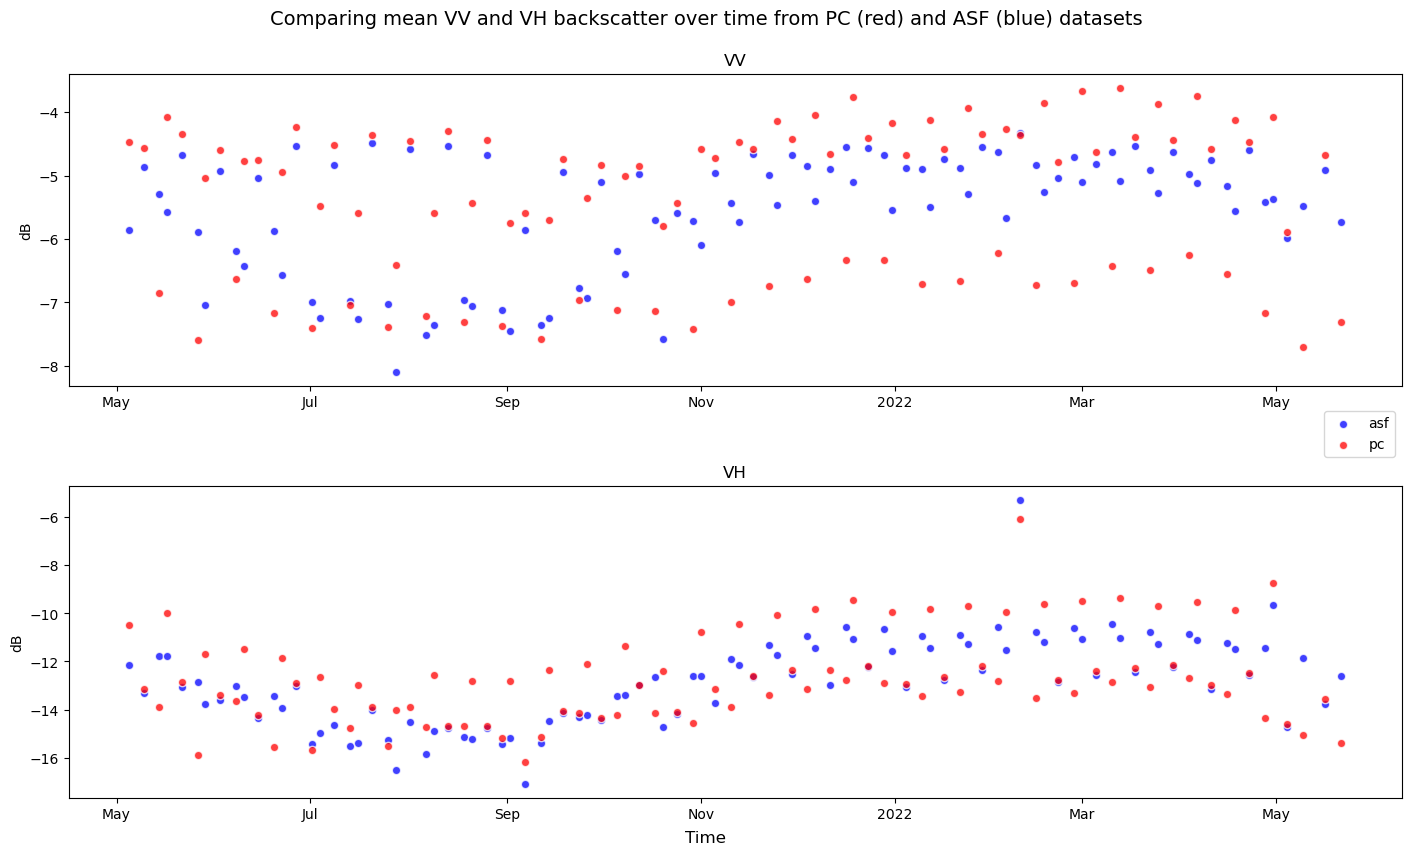

In [251]:
fig, ax = plt.subplots(nrows=2, figsize=(14,8), layout='constrained')
s1_tools.power_to_db(comparison_obj.sel(source='asf',band='vv').mean(dim=['x','y'])).plot.scatter(x='time', ax=ax[0], label='asf',
                                                                                                  c='b', alpha=0.75)
s1_tools.power_to_db(comparison_obj.sel(source='pc',band='vv').mean(dim=['x','y'])).plot.scatter(x='time', ax=ax[0], label='pc',
                                                                                                 c='r',alpha=0.75)

s1_tools.power_to_db(comparison_obj.sel(source='asf',band='vh').mean(dim=['x','y'])).plot.scatter(x='time', ax=ax[1], label='asf',
                                                                                                  c='b',alpha=0.75)
s1_tools.power_to_db(comparison_obj.sel(source='pc',band='vh').mean(dim=['x','y'])).plot.scatter(x='time', ax=ax[1], label='pc',
                                                                                                 c='r',alpha=0.75)
ax[0].legend(loc='lower right', bbox_to_anchor=([1,-.25,0,0]))

for i in range(len(ax)):
    ax[i].set_xlabel(None)
    ax[i].set_ylabel('dB');

ax[0].set_title('VV')
ax[1].set_title('VH')

fig.supxlabel('Time')
#fig.supylabel('dB')
fig.suptitle('Comparing mean VV and VH backscatter over time from PC (red) and ASF (blue) datasets', fontsize=14, y=1.05);

{{conclusion}}